In [1]:
import ROOT
import numpy as np
import root_numpy as rnp
from plotly.offline import init_notebook_mode, iplot
import pandas as pd

## Constant Definition

In [2]:
NFLOORS = 18
NSTRING = 115
PMTSPERDOM = 31
pmtstot = NFLOORS * NSTRING * PMTSPERDOM
ndoms = NFLOORS * NSTRING

In [3]:
coord_origin = np.asarray((13.887,6.713,405.932))

### execute this cell to load files on the Vagrant machine

In [4]:
detfile = "../trigger_optimisation_files/km3net_jul13_90m.detx"
nuefile = "../../ROOT_files/km3_v4_nuecc_1.evt.JTE.aa.root"
numufile = "../../ROOT_files/km3_v4_numucc_1_B.evt.aa.root"

### execute this cell to load files on server

In [4]:
detfile = "utilities/km3net_jul13_90m.detx"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"

In [5]:
from detector_positions import structured_positions

In [6]:
pdoms, ppmts = structured_positions(detfile)

### `ch_id` (Channel ID)

For each _hit_, `ch_id` contains the IDs of each hit PMT (i.e. PMT that receives signal).


The total number of PMTs is `NFLOORS * NSTRING * PMTSPERDOM` (see `pmtstot`) 

#### Description:

* Size: 
* Ndims: 
* Type: `numpy.array`
* Dtype: `np.bool`

### `dom_id` (Dom ID)

For each _hit_, `dom_id` contains the IDs of each hit DOM (i.e. DOM that receives signal)

The total number of DOMs is `NFLOORS * NSTRING` (see `ndoms`) 

#### Description:

* Size: 
* Ndims: 
* Type: `numpy.array`
* Dtype: `np.bool`

### `trig` (Triggered)

For each _hit_, `trig` is a mask (i.e. Boolean array) indicating whether the corresponding hit has been triggered or not.

#### Description:

* Size: 
* Ndims: 
* Type: `numpy.array`
* Dtype: `np.bool`

In [7]:
def import_trees(filename):
    ch_id = rnp.root2array(filename, treename="E", branches="Evt.hits.channel_id")
    dom_id = rnp.root2array(filename, treename="E", branches="Evt.hits.dom_id")
    trig = rnp.root2array(filename, treename= "E", branches="Evt.hits.trig")
    t = rnp.root2array(filename, treename="E", branches="Evt.hits.t")
    times = np.asarray([t[evt][trig[evt]==True] for evt in range(t.size)])
    
    return ch_id, dom_id, trig, times

### doms and pmts hit for numu and nue files

In [9]:
ch_id_numu, dom_id_numu, trig_numu, times_numu = import_trees(numufile)
ch_id_nue, dom_id_nue, trig_nue, times_nue = import_trees(nuefile)

In [10]:
def hits_positions_numu(evt):
    dom_filter_numu = dom_id_numu[evt][trig_numu[evt]==True]-1
    pmt_filter_numu = (dom_filter_numu * PMTSPERDOM) + ch_id_numu[evt][trig_numu[evt]==True]
    ppmts_hit = ppmts[pmt_filter_numu]
    pdoms_hit = pdoms[dom_filter_numu]
    return ppmts_hit, pdoms_hit

pmts_hit_numu = []
doms_hit_numu = []
for evt in range(0, dom_id_numu.size):
    pm,dm = hits_positions_numu(evt)
    pmts_hit_numu.append(pm)
    doms_hit_numu.append(dm)

pmts_hit_numu = np.asarray(pmts_hit_numu)
doms_hit_numu = np.asarray(doms_hit_numu)

In [11]:
def hits_positions_nue(evt):
    dom_filter_nue = dom_id_nue[evt][trig_nue[evt]==True]-1
    pmt_filter_nue = (dom_filter_nue * PMTSPERDOM) + ch_id_nue[evt][trig_nue[evt]==True]
    ppmts_hit = ppmts[pmt_filter_nue]
    pdoms_hit = pdoms[dom_filter_nue]
    return ppmts_hit, pdoms_hit

pmts_hit_nue = []
doms_hit_nue = []
for evt in range(0, dom_id_nue.size):
    pe,de = hits_positions_nue(evt)
    pmts_hit_nue.append(pe)
    doms_hit_nue.append(de)

pmts_hit_nue = np.asarray(pmts_hit_nue)
doms_hit_nue = np.asarray(doms_hit_nue)

### Event selection

###  select events with at least 8 doms hit

In [12]:
doms_hit_sel = []
for evt in range(doms_hit_numu.size):
    if len(np.unique(doms_hit_numu[evt]))>=8:
        doms_hit_sel.append(np.unique(doms_hit_numu[evt]))
doms_hit_sel = np.asarray(doms_hit_sel)

### Clustering algorithm using scikit-learn

### create array with `2070*n_events` locations, one per DOM, in which entries==0 if the dom is not hit, and entries==1 if the dom has been hit. 

In [13]:
X = np.zeros((dom_id_nue.shape[0], ndoms))

for i in range(dom_id_nue.size):
    X[i][(dom_id_nue[i][trig_nue[i]==True]-1)]=1

In [14]:
X_sel = []
for i in range(X.shape[0]):
    if np.sum(X[i])>= 50:
        #print(np.sum(X[i]))
        X_sel.append(i)

In [110]:
sel_X = X[X_sel]
print(sel_X.shape)

(179, 2070)


In [111]:
from sklearn.cluster import SpectralClustering

In [112]:
spectral = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")

In [113]:
spectral

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [114]:
spectral.fit(sel_X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [115]:
C = spectral.affinity_matrix_

In [116]:
C.shape

(179, 179)

In [117]:
C[0,1]==C[1,0]

True

In [118]:
c_ids = spectral.labels_.astype(np.int)

In [119]:
c_ids.shape

(179,)

In [120]:
C[0,0]

1.0

In [121]:
C_dis = 1 - C.todense()

In [122]:
from sklearn.manifold import MDS

In [123]:
mds = MDS(n_components=2, dissimilarity='precomputed')

In [124]:
C_dis_mds = mds.fit_transform(C_dis)

In [125]:
C_dis_mds.shape

(179, 2)

In [126]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])

In [127]:
%matplotlib inline

In [128]:
from matplotlib import pyplot as plt

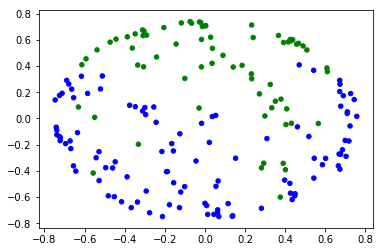

In [129]:
plt.scatter(C_dis_mds[:,0], C_dis_mds[:, 1], color=colors[c_ids].tolist(), s=20)
plt.show()

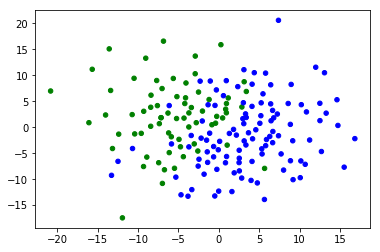

In [130]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(sel_X)
plt.scatter(X_mds[:,0], X_mds[:, 1], color=colors[c_ids].tolist(), s=20)
plt.show()

---

In [107]:
np.where(c_ids==1)

(array([ 1,  3,  5,  6, 15, 17, 18, 23, 24, 25, 26, 27, 31, 34, 35, 36, 40,
        41, 43, 45, 47, 48, 51, 53, 54, 57, 58, 59, 60, 61, 63, 64, 68, 70]),)

In [108]:
np.where(c_ids==0)

(array([ 0,  2,  4,  7,  8,  9, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 28,
        29, 30, 32, 33, 37, 38, 39, 42, 44, 46, 49, 50, 52, 55, 56, 62, 65,
        66, 67, 69, 71, 72]),)

In [198]:
sel_X.shape

(126, 2070)

In [199]:
c_ids.shape

(126,)

### create Data structure with the id of the hit DOMs and the discretized times

In [12]:
timeslices_numu = np.arange(np.min(np.hstack(times_numu))-1000, np.max(np.hstack(times_numu))+1000, 200)
print(timeslices_numu)

[ 49992098.  49992298.  49992498.  49992698.  49992898.  49993098.
  49993298.  49993498.  49993698.  49993898.  49994098.  49994298.
  49994498.  49994698.  49994898.  49995098.  49995298.  49995498.
  49995698.  49995898.  49996098.  49996298.  49996498.  49996698.
  49996898.  49997098.  49997298.  49997498.  49997698.  49997898.
  49998098.  49998298.  49998498.  49998698.  49998898.  49999098.
  49999298.  49999498.  49999698.  49999898.  50000098.  50000298.
  50000498.  50000698.  50000898.  50001098.  50001298.  50001498.
  50001698.  50001898.  50002098.  50002298.  50002498.  50002698.
  50002898.  50003098.  50003298.  50003498.  50003698.  50003898.
  50004098.  50004298.  50004498.  50004698.  50004898.  50005098.]


In [13]:
timeslices_nue = np.arange(np.min(np.hstack(times_nue))-1000, np.max(np.hstack(times_nue))+1000, 200)
print(timeslices_nue)

[ 49996887.  49997087.  49997287.  49997487.  49997687.  49997887.
  49998087.  49998287.  49998487.  49998687.  49998887.  49999087.
  49999287.  49999487.  49999687.  49999887.  50000087.  50000287.
  50000487.  50000687.  50000887.  50001087.  50001287.  50001487.
  50001687.]


In [12]:
min_t_nue = np.min(np.hstack(times_nue))
max_t_nue = np.max(np.hstack(times_nue))
min_t_numu = np.min(np.hstack(times_numu))
max_t_numu= np.max(np.hstack(times_numu))

In [13]:
timeslices = np.arange(np.min((min_t_nue, min_t_numu)), np.max((max_t_nue, max_t_numu)), 200)

In [14]:
timeslices

array([ 49993098.,  49993298.,  49993498.,  49993698.,  49993898.,
        49994098.,  49994298.,  49994498.,  49994698.,  49994898.,
        49995098.,  49995298.,  49995498.,  49995698.,  49995898.,
        49996098.,  49996298.,  49996498.,  49996698.,  49996898.,
        49997098.,  49997298.,  49997498.,  49997698.,  49997898.,
        49998098.,  49998298.,  49998498.,  49998698.,  49998898.,
        49999098.,  49999298.,  49999498.,  49999698.,  49999898.,
        50000098.,  50000298.,  50000498.,  50000698.,  50000898.,
        50001098.,  50001298.,  50001498.,  50001698.,  50001898.,
        50002098.,  50002298.,  50002498.,  50002698.,  50002898.,
        50003098.,  50003298.,  50003498.,  50003698.,  50003898.,
        50004098.])

In [15]:
def X_creation(timeslices, dom_id, trig, times):
    numu_events = dom_id.shape[0]
    n_timeslices = timeslices.shape[0] - 1

    X_nu = np.zeros((numu_events, n_timeslices, ndoms))

    # timeslices = np.arange.....

    # Get Hit count for each timeslice
    for evt in range(numu_events):
        # Get all DOM ids for all triggered hits in current event
        triggered_dom_ids = (dom_id[evt][trig[evt] == True]) - 1
        #print("triggered_dom_ids", triggered_dom_ids)
        times_event_hits = times[evt] # select only hits for current event 
        #print("times_event_hits", times_event_hits)
        for ts, tslice in enumerate(zip(timeslices[:-1], timeslices[1:])):
            low, high = tslice
            #print("low", low, "high", high)
            # hits will hold indices of hits matching the condition of being in the selected timeslice
            hits = np.where((times_event_hits >= low) & (times_event_hits < high))[0]
            if not len(hits):
                continue
            # Get all DOM ids associated to all hits in current time slice.
            dom_hit_in_slice = triggered_dom_ids[hits]
            #print("dom_hits_in_slice", dom_hit_in_slice)
            #print("hits", hits)
            #print(hits.shape)
            # Activate all DOMs for current event, timeslice.
            X_nu[evt, ts, dom_hit_in_slice] = 1
            return X_nu
        #break


In [16]:
X_numu = X_creation(timeslices, dom_id_numu, trig_numu, times_numu)

In [17]:
X_nue = X_creation(timeslices, dom_id_nue, trig_nue, times_nue)

In [18]:
X_numu.shape

(1541, 55, 2070)

In [19]:
X_nue.shape

(1183, 55, 2070)

In [20]:
Y_numu = np.ones(dom_id_numu.shape[0])
Y_nue = np.zeros(dom_id_nue.shape[0])

In [21]:
Y_numu.shape

(1541,)

In [22]:
Y_nue.shape

(1183,)

### select random indices to extract a portion of the data to use as test

In [25]:
indices_numu = np.random.randint(0, X_numu.shape[0]-1, 150)

In [26]:
indices_nue = np.random.randint(0, X_nue.shape[0]-1, 150)

In [27]:
indices_numu

array([ 819,  267,  529, 1407,   82,  981,  129,  185, 1095, 1295, 1250,
       1479,  705,  818,  679, 1226,  619,  495, 1287,   74,  571,  247,
       1384, 1354, 1429, 1535,  438,  180,  150, 1115,  997,  234,  638,
       1183, 1011, 1196,  442,  929,  657,  783, 1384,  957, 1138, 1482,
        414,  892,    5,  166, 1415,  291, 1218, 1018, 1367,  286, 1104,
        892,  703,  741, 1523,  646,   53, 1501,  620,  472,  585,  431,
       1382,  418,  313, 1022,  547, 1346,  622,  530,  890,   42, 1383,
        573,  751,  160,  270,  746,   82,  243, 1499,  400,  999,  424,
       1465,  503,  941,  269,  902,   69,   14, 1384, 1478,  140,  693,
       1028, 1165, 1117, 1115, 1253,  820,  613,  179, 1065, 1083,  721,
       1471,  815, 1145,  845,  934, 1177, 1330,  950,  813,   48, 1080,
        754,  347, 1119,  374, 1103, 1264, 1512,  425,  291, 1000, 1331,
        890, 1286,  964,  909,   66,  433,  947,  219,  323, 1126, 1066,
       1206,  881, 1346,  973,  924,   19,  201])

In [28]:
indices_nue

array([ 163,  968,  709,  591,  298,  583,   71,  909,  266, 1029,  906,
       1119,  582,  171,    3,  155,  970,  748,  455,  605,  926,  501,
        462,  376,   81,  395, 1052,  542, 1151,   65,   66, 1107,  781,
       1020,  440, 1108, 1118, 1111,  493,  642,  998,  663,  465,  804,
        430,  715, 1017, 1055,  823,    5,   66,  501,  242,  669,  919,
        682,  470,  519,  582,  885,   56,  889,  841, 1156,  589,  667,
       1061,  770,  118,  986, 1119, 1003,  969, 1006,  430,  728,   90,
       1161,  872,  770,  610,  553,  535,   93,   41,  950,   62,  657,
        895,  389,  305,  343, 1041,  843, 1095, 1092,  540,  392,  904,
        176,  841, 1099,  241,  481,  201,  496, 1163,  614,   50,  410,
        950,  508,  866, 1058,  963,  554,  223,  559,  915,  695, 1100,
        423,  950,  434,  715,  771,  702, 1170,  147,  489,   18, 1055,
        834,  374,  775,  993,  886,  259,  855, 1042, 1024,  742,  407,
        678,  683, 1093,  316,  153,  317,  243])

### Select a fraction of the events to use as test data

In [31]:
X_numu_test = X_numu[indices_numu]
Y_numu_test = Y_numu[indices_numu]

In [32]:
X_numu_test.shape

(150, 55, 2070)

In [33]:
Y_numu_test.shape

(150,)

In [34]:
X_nue_test = X_nue[indices_nue]
Y_nue_test = Y_nue[indices_nue]

In [35]:
X_nue_test.shape

(150, 55, 2070)

In [36]:
Y_nue_test.shape

(150,)

### Delete the test data from the whole dataset to obtain the data for training

In [37]:
X_numu_train = np.delete(X_numu, indices_numu, axis=0)
X_nue_train = np.delete(X_nue, indices_nue, axis=0)

In [38]:
Y_numu_train = np.delete(Y_numu, indices_numu, axis=0)
Y_nue_train = np.delete(Y_nue, indices_nue, axis=0)

In [40]:
X_numu.shape

(1541, 55, 2070)

In [39]:
X_numu_train.shape

(1399, 55, 2070)

In [40]:
X_numu_test.shape

(150, 55, 2070)

In [41]:
np.delete?

### create dataset with both numu and nue data

In [44]:
X_train = np.vstack((X_numu_train, X_nue_train))

In [45]:
X_test = np.vstack((X_numu_test, X_nue_test))

### reshape dataset down to 2 dimensions

In [46]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

In [47]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [68]:
X_train.shape

(2440, 113850)

In [69]:
X_test.shape

(300, 113850)

### Use `sklearn` to split train and test data

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = np.vstack((X_numu, X_nue))

In [26]:
from keras.utils import np_utils

In [27]:
y_numu_categ = np_utils.to_categorical(Y_numu, 2)
y_nue_categ = np_utils.to_categorical(Y_nue, 2)

In [28]:
y = np.concatenate((y_numu_categ, y_nue_categ))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42)

In [30]:
X_train.shape

(2179, 55, 2070)

In [31]:
X_test.shape

(545, 55, 2070)

In [32]:
y_train.shape

(2179, 2)

In [33]:
y_test.shape

(545, 2)

In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

### convert Y to binary class matrix.


In [79]:
Y_numu_train = np_utils.to_categorical(Y_numu_train, 2)
Y_nue_train = np_utils.to_categorical(Y_nue_train, 2)

In [80]:
Y_numu_test = np_utils.to_categorical(Y_numu_test, 2)
Y_nue_test = np_utils.to_categorical(Y_nue_test, 2)

In [81]:
y_train = np.concatenate((Y_numu_train, Y_nue_train))

In [83]:
y_test = np.concatenate((Y_numu_test, Y_nue_test))

In [56]:
X_train.shape

(2440, 113850)

In [82]:
y_train.shape

(2440, 2)

### shuffle the X and y arrays using the same indices

In [58]:
permutation = np.random.permutation(y_train.shape[0])

In [59]:
permutation.shape

(2440,)

In [60]:
perm_X_train = X_train[permutation]
perm_y_train = y_train[permutation]

In [61]:
perm_test = np.random.permutation(y_test.shape[0])
perm_X_test = X_test[perm_test]
perm_y_test = y_test[perm_test]

In [77]:
X_train.shape

(2440, 113850)

In [86]:
y_train.shape

(2440, 2)

In [87]:
perm_X_test.shape

(300, 113850)

In [91]:
perm_y_train.shape

(2440,)

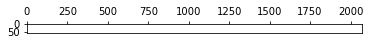

In [55]:
from matplotlib import pyplot
import matplotlib as mpl
%matplotlib inline

# Displaying the first training data
fig = pyplot.figure()
ax = fig.add_subplot(1,1,1)
imgplot = ax.imshow(X_train[1000], cmap=mpl.cm.Greys)
imgplot.set_interpolation('nearest')
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
pyplot.show()

### definition of the network 

In [76]:
#### early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model = Sequential()
model.add(Dense(2070, input_shape=((X_train.shape[1], X_train.shape[2])), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2070, activation = 'relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 55, 2070)          4286970   
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 2070)          0         
_________________________________________________________________
dense_28 (Dense)             (None, 55, 2070)          4286970   
_________________________________________________________________
flatten_3 (Flatten)          (None, 113850)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 227702    
Total params: 8,801,642
Trainable params: 8,801,642
Non-trainable params: 0
_________________________________________________________________


In [77]:
network_history = model.fit(X_train, y_train, batch_size=115, 
                            epochs=20, verbose=1, validation_data=(X_test, y_test), 
                            callbacks=[early_stop])

Train on 2179 samples, validate on 545 samples
Epoch 1/20
2179/2179 [==============================] - 52s - loss: 0.6920 - acc: 0.5530 - val_loss: 0.6905 - val_acc: 0.5688
Epoch 2/20
2179/2179 [==============================] - 53s - loss: 0.6897 - acc: 0.5649 - val_loss: 0.6884 - val_acc: 0.5688
Epoch 3/20
2179/2179 [==============================] - 53s - loss: 0.6880 - acc: 0.5649 - val_loss: 0.6869 - val_acc: 0.5688
Epoch 4/20
2179/2179 [==============================] - 53s - loss: 0.6869 - acc: 0.5649 - val_loss: 0.6858 - val_acc: 0.5688
Epoch 5/20
2179/2179 [==============================] - 54s - loss: 0.6861 - acc: 0.5649 - val_loss: 0.6851 - val_acc: 0.5688
Epoch 6/20
2179/2179 [==============================] - 54s - loss: 0.6856 - acc: 0.5649 - val_loss: 0.6846 - val_acc: 0.5688
Epoch 7/20
2179/2179 [==============================] - 54s - loss: 0.6853 - acc: 0.5649 - val_loss: 0.6843 - val_acc: 0.5688
Epoch 8/20
2179/2179 [==============================] - 54s - loss: 0.6

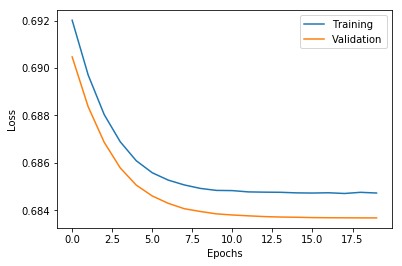

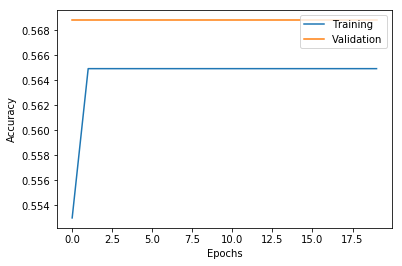

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(network_history.history['loss'])
plt.plot(network_history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(network_history.history['acc'])
plt.plot(network_history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='upper right')

### Try with a different kind of network

In [ ]:
#### early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model = Sequential()
model.add(Dense(2070, input_shape=((X_train.shape[1], X_train.shape[2])), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2070, activation = 'relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [81]:
from keras.layers import Conv2D

In [ ]:
VGG16

In [82]:
# apply a 3x3 convolution with 64 output filters on a 256x256 image:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', 
          input_shape=((X_train.shape[1], X_train.shape[2]))))
#pooling
#batch normalization
#relu
# add a 3x3 convolution on top, with 32 output filters:
model.add(Conv2D(32, (3, 3), padding='same'))
# now model.output_shape == (None, 256, 256, 32)
model.add(Flatten())
model.add(Dense(2))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2179, 55, 2070)    38566170  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2179, 55, 2)       37262     
_________________________________________________________________
flatten_4 (Flatten)          (None, 239690)            0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 479382    
Total params: 39,082,814
Trainable params: 39,082,814
Non-trainable params: 0
_________________________________________________________________


In [83]:
network_history2 = model.fit(X_train, y_train, batch_size=115, 
                            epochs=20, verbose=1, validation_data=(X_test, y_test), 
                            callbacks=[early_stop])

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (2179, 55, 2070)